In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
from datetime import timedelta


In [140]:
# Load CSV
df = pd.read_csv('Unilever Pakistan Foods Stock Price History.csv')

# Clean column names and types
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date', 'Price', 'Open', 'High', 'Low']]
df[['Open', 'High', 'Low']] = df[['Open', 'High', 'Low']].replace(',', '', regex=True).astype(float)

# Sort by date
df = df.sort_values('Date').dropna()
df.reset_index(drop=True, inplace=True)


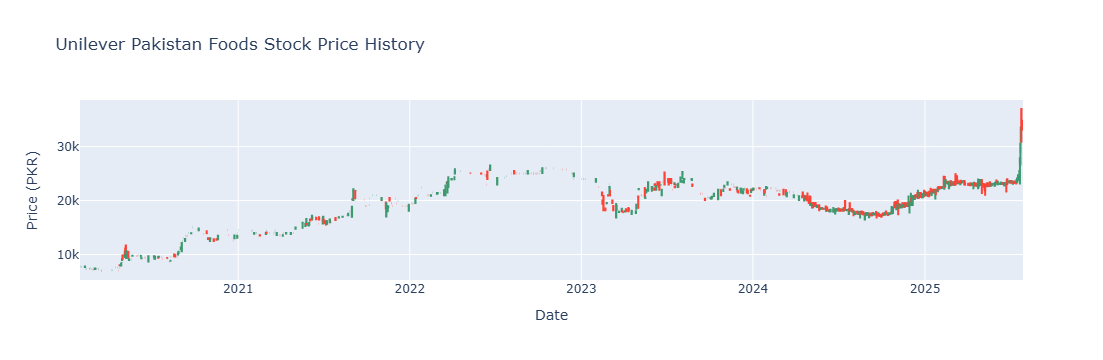

In [154]:
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Price'],
    name='Candlestick'
)])
fig.update_layout(
    title='Unilever Pakistan Foods Stock Price History',
    xaxis_title='Date',
    yaxis_title='Price (PKR)',
    xaxis_rangeslider_visible=False
)
fig.show()


In [142]:
# Normalize price
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['Price']])

# Create sequences
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(scaled_prices, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [143]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1)


Epoch 1/300


C:\Users\Natha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1129
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0073
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0042
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0024
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
Epoch 9/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016
Epoch 10/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
Epoch 11/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015
Epoch 12/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018
Epoch 13/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014
Epoch 14/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017
Epoch 15/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
E

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


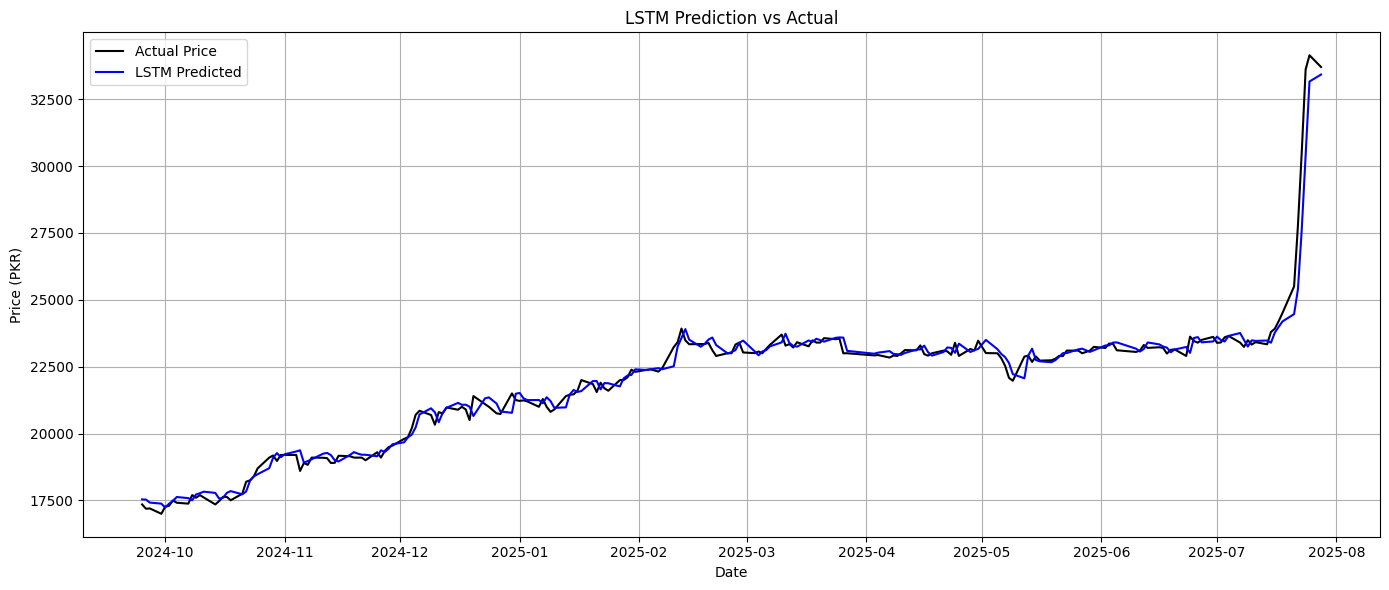

In [144]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get test dates
test_dates = df['Date'].iloc[look_back + train_size:]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label='Actual Price', color='black')
plt.plot(test_dates, predicted, label='LSTM Predicted', color='blue')
plt.title('LSTM Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (PKR)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [145]:
# Get last 60 days from full dataset for forecasting
last_sequence = scaled_prices[-look_back:]
input_seq = last_sequence.reshape(1, look_back, 1)

# Predict next 365 days
future_steps = 365
future_preds = []
for _ in range(future_steps):
    pred = model.predict(input_seq)[0][0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

# Convert to dates
last_date = df['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(future_steps)]
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Combine forecast into DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_prices.flatten()})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [146]:
future_df 

,Date,Predicted_Price
0,2025-07-29,32825.769531
1,2025-07-30,32488.824219
2,2025-07-31,32815.144531
3,2025-08-01,33501.449219
4,2025-08-02,34089.214844
...,...,...
360,2026-07-24,24844.705078
361,2026-07-25,24844.697266
362,2026-07-26,24844.685547
363,2026-07-27,24844.675781


In [147]:
# Predict on test data
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\Natha\AppData\Local\Temp\ipykernel_21324\3606723420.py:14: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



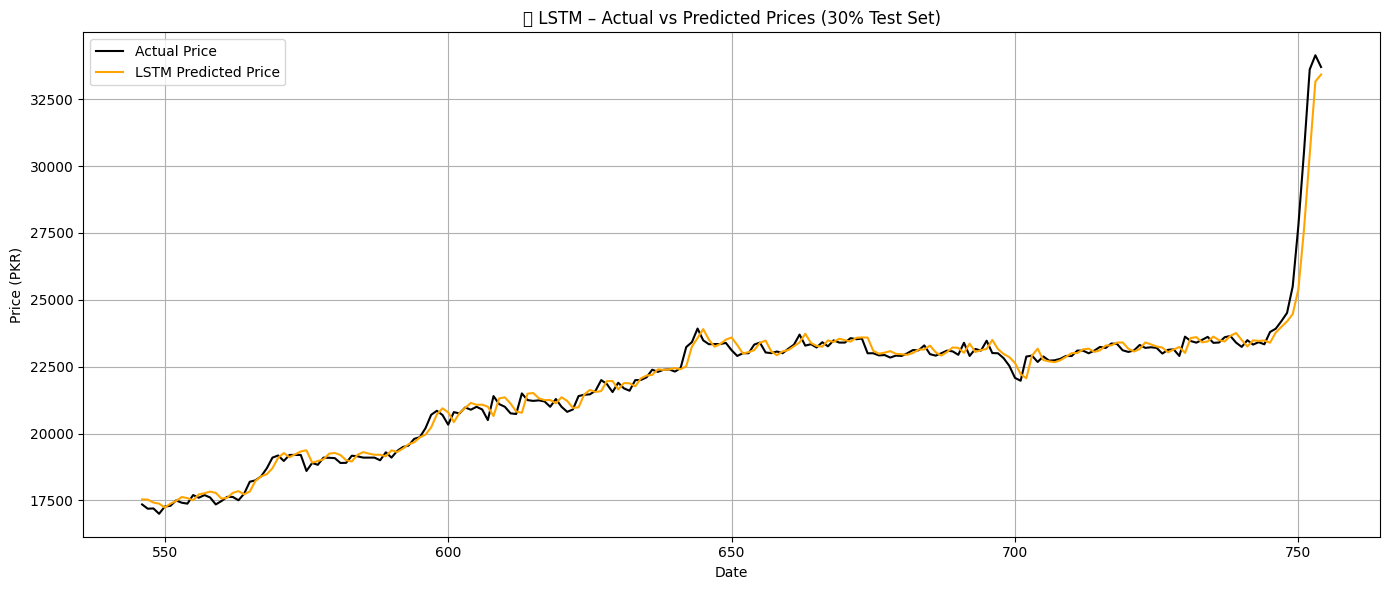

In [148]:
import matplotlib.pyplot as plt

# Adjust index for test set plot
test_dates = df.index[train_size + look_back:]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual Price', color='black')
plt.plot(test_dates, test_predictions_rescaled, label='LSTM Predicted Price', color='orange')
plt.title('📉 LSTM – Actual vs Predicted Prices (30% Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (PKR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [149]:
# Investment date
invest_date = pd.to_datetime('2025-06-01')
target_dates = ['2025-09-01', '2025-12-01', '2026-06-01']
target_dates = pd.to_datetime(target_dates)

# Get latest known price (used for investment)
buy_price = df[df['Date'] <= invest_date]['Price'].iloc[-1]
shares = 10000 / buy_price

print(f"Investment on {invest_date.date()}:")
print(f"Buy Price: {buy_price:.2f} PKR")
print(f"Shares bought: {shares:.4f}")

# Predict price for each target date
for td in target_dates:
    if td in future_df['Date'].values:
        pred_price = future_df[future_df['Date'] == td]['Predicted_Price'].values[0]
    else:
        pred_price = future_df.iloc[(future_df['Date'] - td).abs().argsort()[:1]]['Predicted_Price'].values[0]
    
    value = shares * pred_price
    profit = value - 10000
    print(f"\n📅 On {td.date()}:")
    print(f"Predicted Price: {pred_price:.2f} PKR")
    print(f"Value of Investment: {value:.2f} PKR")
    print(f"Profit/Loss: {profit:.2f} PKR")


Investment on 2025-06-01:
Buy Price: 23238.10 PKR
Shares bought: 0.4303

📅 On 2025-09-01:
Predicted Price: 27240.32 PKR
Value of Investment: 11722.27 PKR
Profit/Loss: 1722.27 PKR

📅 On 2025-12-01:
Predicted Price: 24677.11 PKR
Value of Investment: 10619.25 PKR
Profit/Loss: 619.25 PKR

📅 On 2026-06-01:
Predicted Price: 24844.13 PKR
Value of Investment: 10691.12 PKR
Profit/Loss: 691.12 PKR


In [152]:
# Save model architecture and weights
model.save('stock_lstm_model.h5')
print("✅ Model saved as 'stock_lstm_model.h5'")


✅ Model saved as 'stock_lstm_model.h5'


In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
print(f"RMSE: {rmse:.2f} PKR")

# MAE
mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
print(f"MAE: {mae:.2f} PKR")

# MAPE
mape = np.mean(np.abs((y_test_rescaled - test_predictions_rescaled) / y_test_rescaled)) * 100
print(f"MAPE (Error Rate): {mape:.2f}%")


RMSE: 432.24 PKR
MAE: 235.17 PKR
MAPE (Error Rate): 1.03%
